In [1]:
%pip install "torch==1.10.2" "shap==0.40.0" "matplotlib==3.5.3" \
             "seaborn==0.11.2" "scikit-learn==0.24.2" \
             "numpy==1.22" "pandas==1.3.5"


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install "matplotlib-inline==0.1.3"

Note: you may need to restart the kernel to use updated packages.


In [3]:
from src.network.customics import CustOMICS
from src.tools.prepare_dataset import prepare_dataset
from src.tools.utils import get_sub_omics_df, get_common_samples
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch

/home/ilaria/.pyenv/versions/3.9.23/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ilaria/.pyenv/versions/3.9.23/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/ilaria/.pyenv/versions/3.9.23/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The im

In [4]:
cohort = 'TCGA-BRCA'
omic_sources = ['CNV','RNAseq','methyl']
label='PAM50'

In [5]:
omics_df = {}
cnv_path = 'TCGA/{}/{}_CNV.csv'.format(cohort,cohort)
rna_path = 'TCGA/{}/{}_mRNA.csv'.format(cohort,cohort)
methyl_path = 'TCGA/{}/{}_Methy.csv'.format(cohort,cohort)
clinical_path = 'TCGA/{}/Clinical_Data.csv'.format(cohort,cohort)
if 'CNV' in omic_sources:
    omics_df['CNV'] = pd.read_csv(cnv_path, sep=',', index_col=0).T.dropna(axis=1)
    omics_df['CNV'].index = omics_df['CNV'].index.str.replace('.', '-', regex=False)
if 'RNAseq' in omic_sources:
    omics_df['RNAseq'] = pd.read_csv(rna_path, sep=',', index_col=0).T.dropna(axis=1)
    omics_df['RNAseq'].index = omics_df['RNAseq'].index.str.replace('.', '-', regex=False)
if 'methyl' in omic_sources:
    omics_df['methyl'] = pd.read_csv(methyl_path, sep=',', index_col=0).T.dropna(axis=1)
    omics_df['methyl'].index = omics_df['methyl'].index.str.replace('.', '-', regex=False)
clinical_df = pd.read_csv(clinical_path, sep=',', index_col=0)
clinical_df = clinical_df[clinical_df['status'].notna()]
clinical_df = clinical_df[clinical_df['days'].notna()]
if cohort == 'TCGA-BRCA':
    clinical_df = clinical_df[clinical_df[label].notna()]
lt_samples = get_common_samples([df for df in omics_df.values()] + [clinical_df])
for source in omics_df.keys():
    omics_df[source] = omics_df[source].loc[lt_samples, :]

In [6]:
lt_samples = list(clinical_df.index)

In [7]:
samples_train, samples_test = train_test_split(lt_samples, test_size=0.2)
samples_train, samples_val = train_test_split(samples_train, test_size=0.2)

In [8]:
omics_train = get_sub_omics_df(omics_df, samples_train)
omics_val = get_sub_omics_df(omics_df, samples_val)
omics_test = get_sub_omics_df(omics_df, samples_test)


x_dim = [omics_df[omic_source].shape[1] for omic_source in omics_df.keys()]

In [9]:
#### Defining Hyperparameters

batch_size = 32
n_epochs = 10
device = torch.device('cpu')
label ='PAM50'
event = 'status'
surv_time = 'days'

task = 'classification'
sources = omic_sources

hidden_dim = [512, 256]
central_dim = [512, 256]
rep_dim = 128
latent_dim=128
num_classes = 5
dropout = 0.2
beta = 1
lambda_classif = 5
classifier_dim = [128, 64]
lambda_survival = 0
survival_dim = [64,32]

source_params = {}
central_params = {'hidden_dim': central_dim, 'latent_dim': latent_dim, 'norm': True, 'dropout': dropout, 'beta': beta}
classif_params = {'n_class': num_classes, 'lambda': lambda_classif, 'hidden_layers': classifier_dim, 'dropout': dropout}
surv_params = {'lambda': lambda_survival, 'dims': survival_dim, 'activation': 'SELU', 'l2_reg': 1e-2, 'norm': True, 'dropout': dropout}
for i, source in enumerate(sources):
    source_params[source] = {'input_dim': x_dim[i], 'hidden_dim': hidden_dim, 'latent_dim': rep_dim, 'norm': True, 'dropout': 0.2}
train_params = {'switch': 5, 'lr': 1e-3}

Number of Parameters:  45485815
	Epoch 1 complete! 	Average Loss Train :  0.6689902586596352 	Average Loss Val :  0.6026881337165833
	Epoch 2 complete! 	Average Loss Train :  0.44330764029707226 	Average Loss Val :  0.4640391021966934
	Epoch 3 complete! 	Average Loss Train :  0.34383042795317514 	Average Loss Val :  0.4247671216726303
	Epoch 4 complete! 	Average Loss Train :  0.2735592243926866 	Average Loss Val :  0.4091434180736542
	Epoch 5 complete! 	Average Loss Train :  0.22008656284638814 	Average Loss Val :  0.3992030695080757
	Epoch 6 complete! 	Average Loss Train :  0.14519416434424265 	Average Loss Val :  0.16670623049139977
	Epoch 7 complete! 	Average Loss Train :  0.10536591549004827 	Average Loss Val :  0.16322412714362144
	Epoch 8 complete! 	Average Loss Train :  0.09634276319827352 	Average Loss Val :  0.15657581388950348
	Epoch 9 complete! 	Average Loss Train :  0.09063033333846501 	Average Loss Val :  0.15147962048649788
	Epoch 10 complete! 	Average Loss Train :  0.086

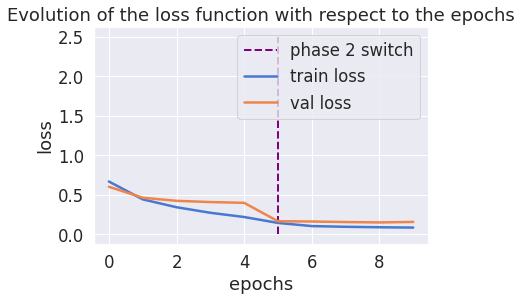

In [10]:
model = CustOMICS(source_params=source_params, central_params=central_params, classif_params=classif_params,
                        surv_params=surv_params, train_params=train_params, device=device).to(device)
print('Number of Parameters: ', model.get_number_parameters())
model.fit(omics_train=omics_train, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
            omics_val=omics_val, batch_size=batch_size, n_epochs=n_epochs, verbose=True)
metric = model.evaluate(omics_test=omics_test, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
                task=task, batch_size=1024, plot_roc=False)
model.plot_loss()


In [20]:
print(metric)

[{'Accuracy': 0.7835820895522388, 'F1-score': 0.7758086051487465, 'Precision': 0.7775135312448745, 'Recall': 0.7835820895522388, 'AUC': 0.945968028947013}]


In [11]:
model.get_latent_representation(omics_df)

array([[-0.14322416,  0.01008239,  0.08832978, ...,  0.27897903,
        -0.22087322, -0.19225793],
       [-0.42471024, -1.230263  , -0.21007437, ..., -0.39861023,
         1.957388  ,  0.27009922],
       [-0.09624009,  0.00663936,  0.15332098, ...,  0.03025217,
        -0.0308888 , -0.24561805],
       ...,
       [-0.17559898,  0.04708375, -0.06285092, ...,  0.164296  ,
        -0.13910744, -0.15172707],
       [-0.62500775,  0.04924214, -0.13192712, ...,  0.41431466,
        -0.6322014 , -0.43067554],
       [-0.6929907 ,  0.04669525, -0.0085382 , ...,  0.26374215,
        -0.51312065, -0.3284157 ]], dtype=float32)

In [12]:
from src.ex_vae.shap_vae import processPhenotypeDataForSamples
expr_df = omics_df['methyl']
sample_id_filtered = list(set(lt_samples) & set(expr_df.index))
phenotype = processPhenotypeDataForSamples(clinical_df, sample_id_filtered, model.label_encoder)
conditionaltumour = phenotype.loc[:, 'PAM50'] == 'Her2' 

print("n sample_id provided:", len(lt_samples))
print("n after intersection:", len(sample_id_filtered))
print("n matching subtype:", conditionaltumour.sum())


n sample_id provided: 670
n after intersection: 670
n matching subtype: 42


In [13]:
print("raw PAM50 counts:\n", clinical_df['PAM50'].value_counts())
print("encoded -> original mapping:", list(zip(model.label_encoder.transform(model.label_encoder.classes_), model.label_encoder.classes_)))


raw PAM50 counts:
 LumA      352
LumB      132
Basal     113
Her2       42
Normal     31
Name: PAM50, dtype: int64
encoded -> original mapping: [(0, 'Basal'), (1, 'Her2'), (2, 'LumA'), (3, 'LumB'), (4, 'Normal')]


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


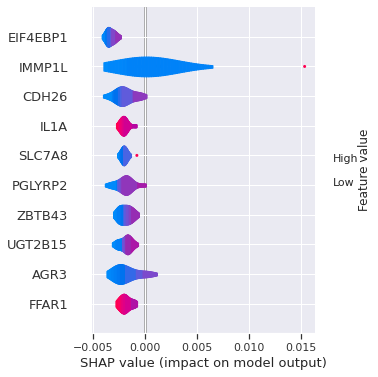

<Figure size 432x288 with 0 Axes>

In [14]:
model.explain(lt_samples, omics_df, clinical_df, 'methyl', 'LumB', 'PAM50', device, show=True)

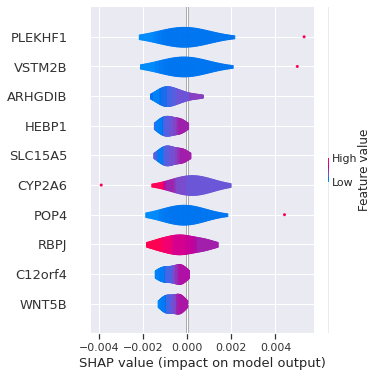

<Figure size 432x288 with 0 Axes>

In [15]:
model.explain(lt_samples, omics_df, clinical_df, 'CNV', 'Her2', 'PAM50', device, show=True)

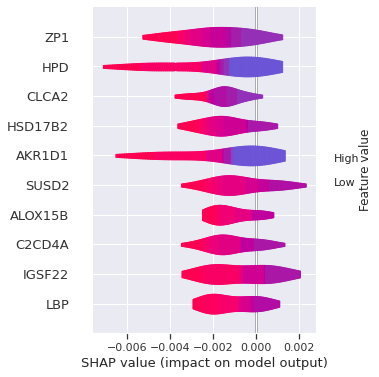

<Figure size 432x288 with 0 Axes>

In [16]:
model.explain(lt_samples, omics_df, clinical_df, 'RNAseq', 'Her2', 'PAM50', device, show=True)

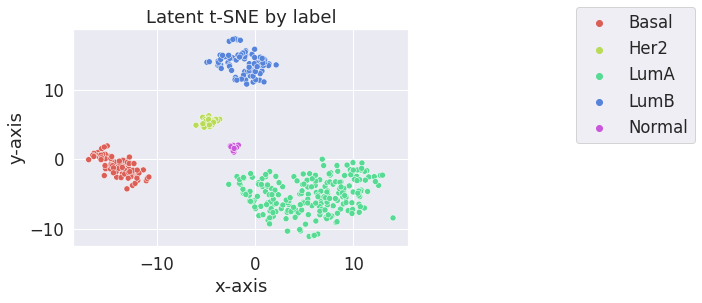

<Figure size 432x288 with 0 Axes>

In [17]:
from src.tools.utils import save_plot_score
z = model.get_latent_representation(omics_df=omics_train)
save_plot_score('latent_tsne', z, clinical_df.loc[omics_train[next(iter(omics_train))].index, label].values,
                title='Latent t-SNE by label', show=True)


z shape: (428, 128)
labels shape: (428,)
First 5 sample IDs: ['TCGA-AC-A2QH-01', 'TCGA-AO-A0JC-01', 'TCGA-AR-A24W-01', 'TCGA-AR-A24T-01', 'TCGA-E9-A3QA-01']
First 5 labels: ['Basal' 'LumA' 'LumA' 'LumA' 'Basal']


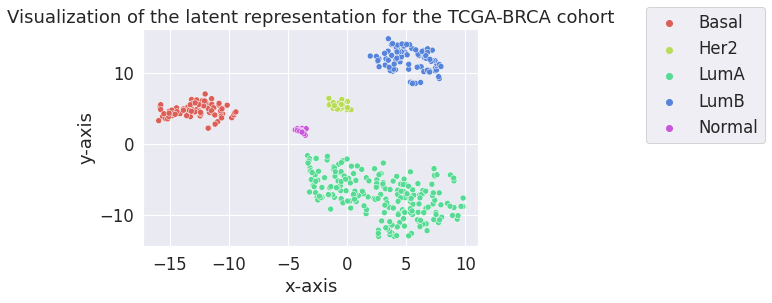

<Figure size 432x288 with 0 Axes>

In [19]:
model.plot_representation(
    omics_df=omics_train,        # or omics_test
    clinical_df=clinical_df,
    labels=label,                # e.g., 'PAM50'
    filename='plot_representation',
    title='Visualization of the latent representation for the TCGA-BRCA cohort',
    show=True
)
